# Guided molecular generation with MolMIM

This tutorial demonstrates how to use the molmim_cma package to optimize exploration of the [MolMIM](https://arxiv.org/abs/2208.09016) model's latent space to generate molecules
with properties of interest. To do this, we use the [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES) genetic optimization algorithm. The basic steps of optimization are:

1. Decode latent representations into smiles strings
2. Score generated smiles strings based on the desired oracle function
3. Update the CMA-ES algorithm with the smiles/score pairing
4. Ask the CMA-ES algorithm for a new set of latent space representations to sample.

### BioNeMo Service Configurations
To get started, please configure and provide your NGC access token by visiting https://ngc.nvidia.com/setup/api-key.

Then we can import and install library dependencies.

In [2]:
from typing import List

import numpy as np

from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
from guided_molecule_gen.oracles import qed, tanimoto_similarity

Next, let's define an oracle function. This function is based on QED and tanimoto similarity scores, and is what was used for property optimization in the [MolMIM paper](https://arxiv.org/abs/2208.09016). 

$$
   score = min(QED / 0.9, 1) + min(Tanimoto / 0.4, 1)
$$

This oracle tries to maximize QED and similarity score, up to QED of 0.9 and similarlity of 0.4, beyond which there is no more gain.

In [3]:
def score_mixing_function(qeds, similarities):
    return np.clip(qeds / 0.9, a_min=0.0, a_max=1.0) + np.clip(similarities / 0.4, a_min=0.0, a_max=1.0)

def scoring_function(smiles: List[str], **kwargs) -> np.ndarray:
    reference: str = kwargs['reference']
    scores: np.ndarray = score_mixing_function(qed(smiles), tanimoto_similarity(smiles, reference))
    return -1 * scores

Note that we've inverted the sign of the return value, as the CMA-ES algorithm will try to minimize the value. 

Now, let's set  up our molecule [imatinib](https://pubchem.ncbi.nlm.nih.gov/compound/Imatinib#section=Computed-Descriptors). We'll run three replicates of optimization simulataneously - you could also seed different molecules here.

Original QED: 0.38941616262964607


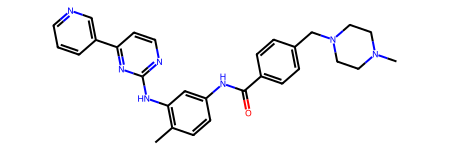

In [4]:
smis = [
    "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5",
    "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5",
    "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5"
]

from rdkit import Chem
from rdkit.Chem.QED import qed as rdkit_qed
mol = Chem.MolFromSmiles(smis[0])
qed_score = rdkit_qed(mol)
print(f"Original QED: {qed_score}")
mol

Next, we'll set up the optimizer. It takes in a client, a scoring function callback (the oracle), and the seed SMILES. The client must implement encode() and decode() methods. For this example, the molmim_cma library provides us a client which wraps the bionemo service.

In [5]:
from guided_molecule_gen.inference_client import BioNemoNIMClient

# Update IP:port below to point to your MolMIM NIM host
service_client = BioNemoNIMClient(nim_host="localhost:8000")

In [6]:
optimizer = MoleculeGenerationOptimizer(service_client, scoring_function, smis, popsize=20, optimizer_args={"sigma":1.3} )

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 512 (seed=194127, Wed Oct 16 17:10:12 2024)
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 512 (seed=238872, Wed Oct 16 17:10:12 2024)
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 512 (seed=273158, Wed Oct 16 17:10:12 2024)


In [7]:
optimizer.original_smis

['CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5',
 'CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5',
 'CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5']

In [8]:
optimizer.step()
initial_generated_smiles = optimizer.generated_smis
initial_qeds = [qed(molecule_smis) for molecule_smis in initial_generated_smiles]
initial_similarities = [tanimoto_similarity(molecule_smis, molecule) for molecule_smis, molecule in zip(initial_generated_smiles, smis)   ]

### Visualizing QED and Similarity scores after first iteration

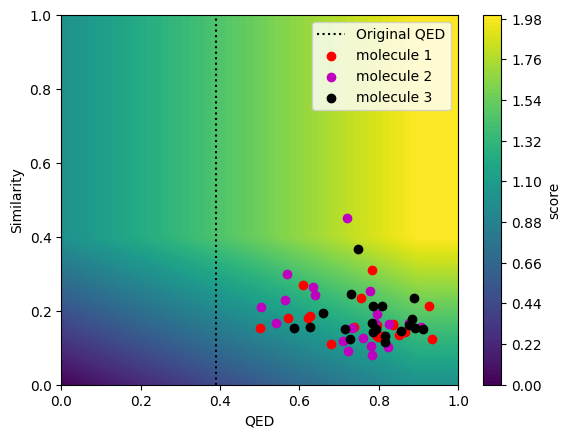

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()
fig, ax = plt.subplots()
colors = ['r', 'm', 'k']
deltas = np.linspace(0, 1, 100)
Xgrid, Ygrid = np.meshgrid(deltas, deltas)
score_background = score_mixing_function(Xgrid, Ygrid)
plt.contourf(Xgrid, Ygrid, score_background, levels=100, vmin=0, vmax=2.0)
plt.colorbar(label='score')
plt.plot([qed_score, qed_score], [0, 1], linestyle=':', c='k', label="Original QED")
dynamic_plots = []
for i, (qeds, sims, color) in enumerate(zip(initial_qeds, initial_similarities, colors)):
    dynamic_plots.append(ax.scatter(qeds, sims, c=color, label=f"molecule {i + 1}"))
plt.xlabel("QED")
plt.ylabel("Similarity")
plt.legend()
plt.draw()


### Visualizing the molecule generation process interactively

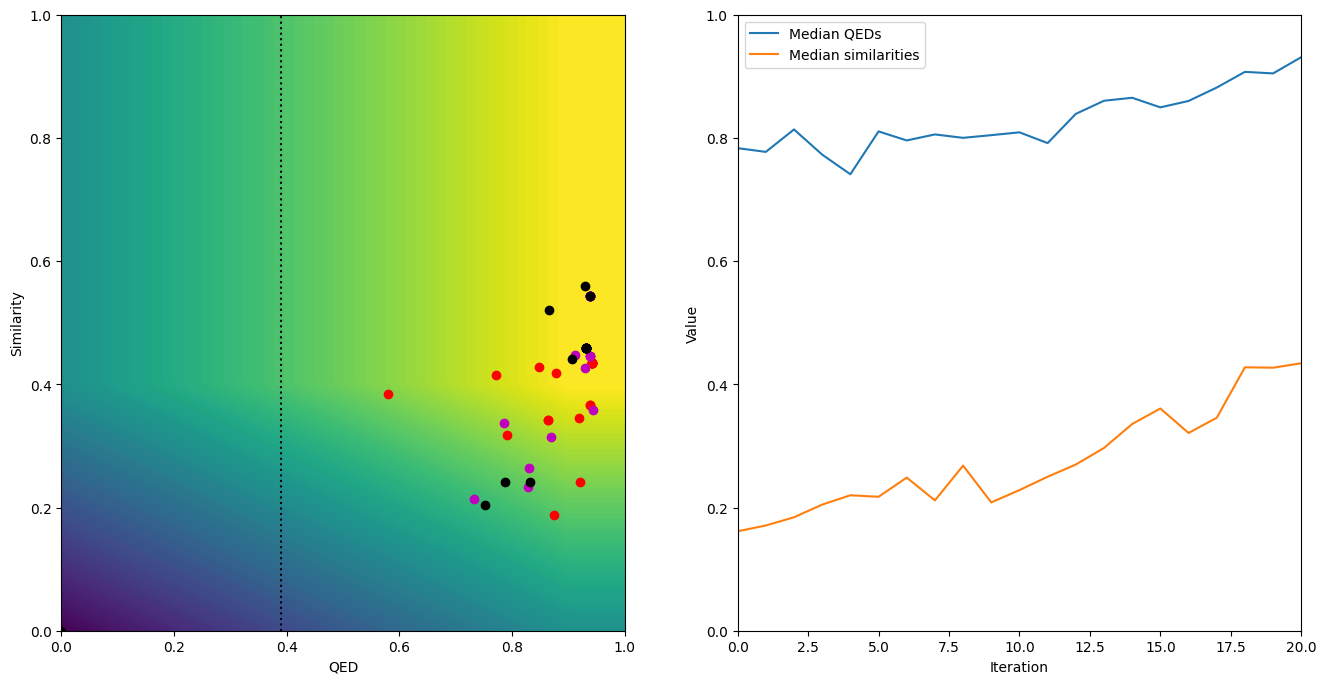

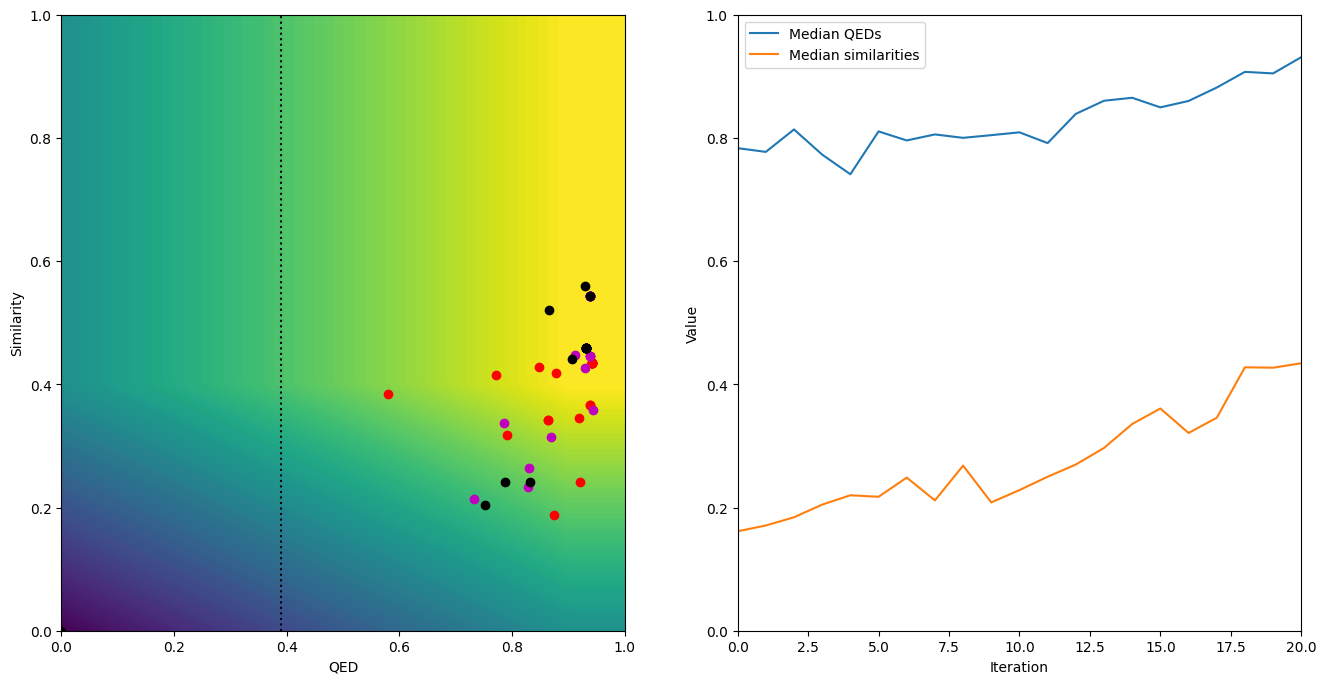

In [10]:
from IPython.display import display, clear_output
%matplotlib inline

n_steps = 20

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(16)
med_qeds = [np.median(np.array(initial_qeds))]
med_sims = [np.median(np.array(initial_similarities))]


for i in range(n_steps):
    # business code
    print(f"Stepping {i} out of {n_steps}")
    optimizer.step()
    qeds = np.array([qed(molecule_smis) for molecule_smis in optimizer.generated_smis])
    similarities = np.array([tanimoto_similarity(molecule_smis, molecule) for molecule_smis, molecule in zip(optimizer.generated_smis, smis)])

    # plotting code
    ax1.clear()
    clear_output(wait=True)
    ax1.contourf(Xgrid, Ygrid, score_background, levels=100, vmin=0, vmax=2.0)
    ax1.set_xlabel('QED')
    ax1.set_ylabel('Similarity')    
    ax1.plot([qed_score, qed_score], [0, 1], linestyle=':', c='k', label="Original QED")
    for i, color in enumerate(colors):
        ax1.scatter(qeds[i, :], similarities[i, :], c=color, label=f"molecule {i + 1}")
    ax2.clear()
    med_qeds.append(np.median(qeds))
    med_sims.append(np.median(similarities))
    ax2.plot(med_qeds, label='Median QEDs')
    ax2.plot(med_sims, label='Median similarities')
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Value")
    ax2.set_xlim(0, n_steps)
    ax2.set_ylim(0, 1)
    ax2.legend()
    display(fig)
    

### Generating molecules with similar properties

What if we want similar molecules with similar properties?

In [11]:
def scoring_mixer(qeds, similarities, target_similarity=0.7, target_qed=0.4):
    # Penalize deviation from goal of 0.7
    similarity_delta = np.abs(target_similarity - similarities)
    qed_delta = np.abs(target_qed - qeds)
    return 1 -  (similarity_delta ** 2 + qed_delta ** 2)


def scoring_function(smiles: List[str], **kwargs) -> np.ndarray:
    reference: str = kwargs['reference']
    qeds = qed(smiles)
    similarities = tanimoto_similarity(smiles, reference)

    return -1 * scoring_mixer(qeds, similarities)


Text(0, 0.5, 'Similarity')

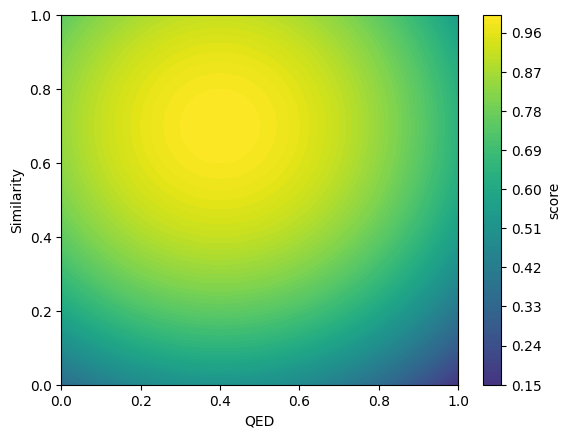

In [12]:
score_background = scoring_mixer(Xgrid, Ygrid)
plt.contourf(Xgrid, Ygrid, score_background, levels=100, vmin=0, vmax=1.0)
plt.colorbar(label='score')
plt.xlabel("QED")
plt.ylabel("Similarity")

In [13]:
optimizer = MoleculeGenerationOptimizer(service_client, scoring_function, smis, popsize=20)

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 512 (seed=232963, Wed Oct 16 17:13:36 2024)
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 512 (seed=159151, Wed Oct 16 17:13:36 2024)
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 512 (seed=163215, Wed Oct 16 17:13:36 2024)


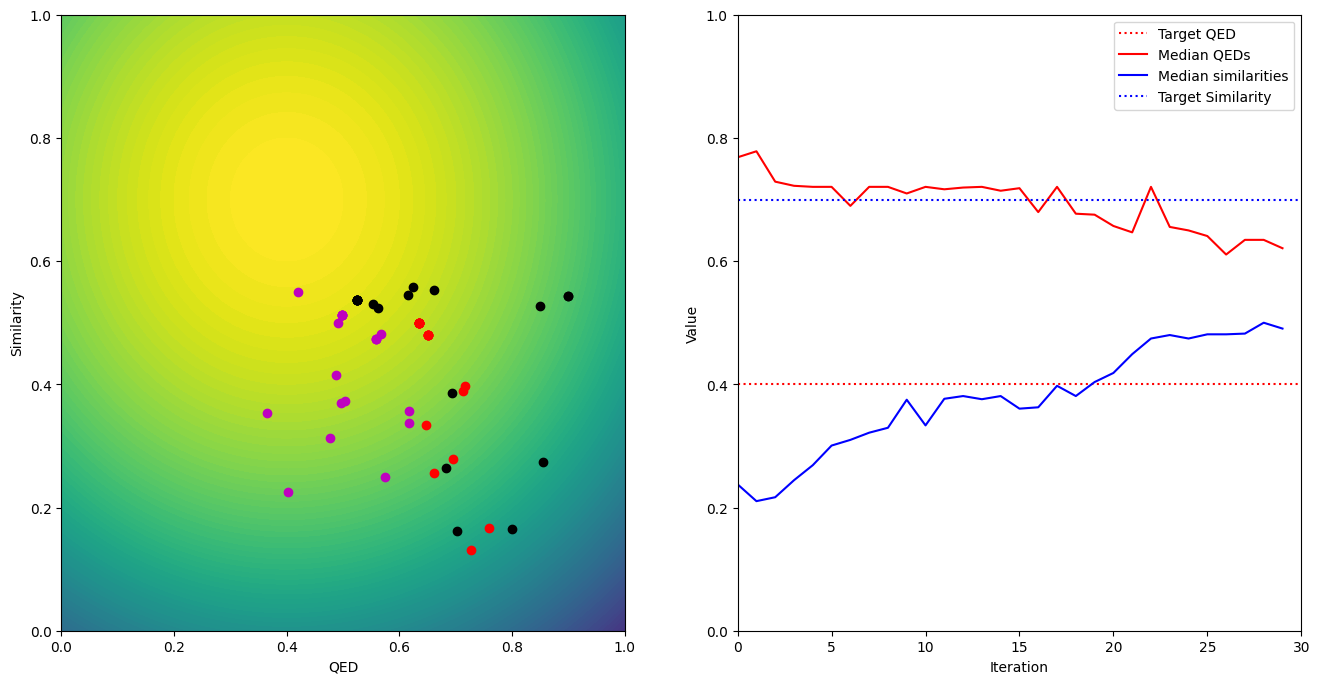

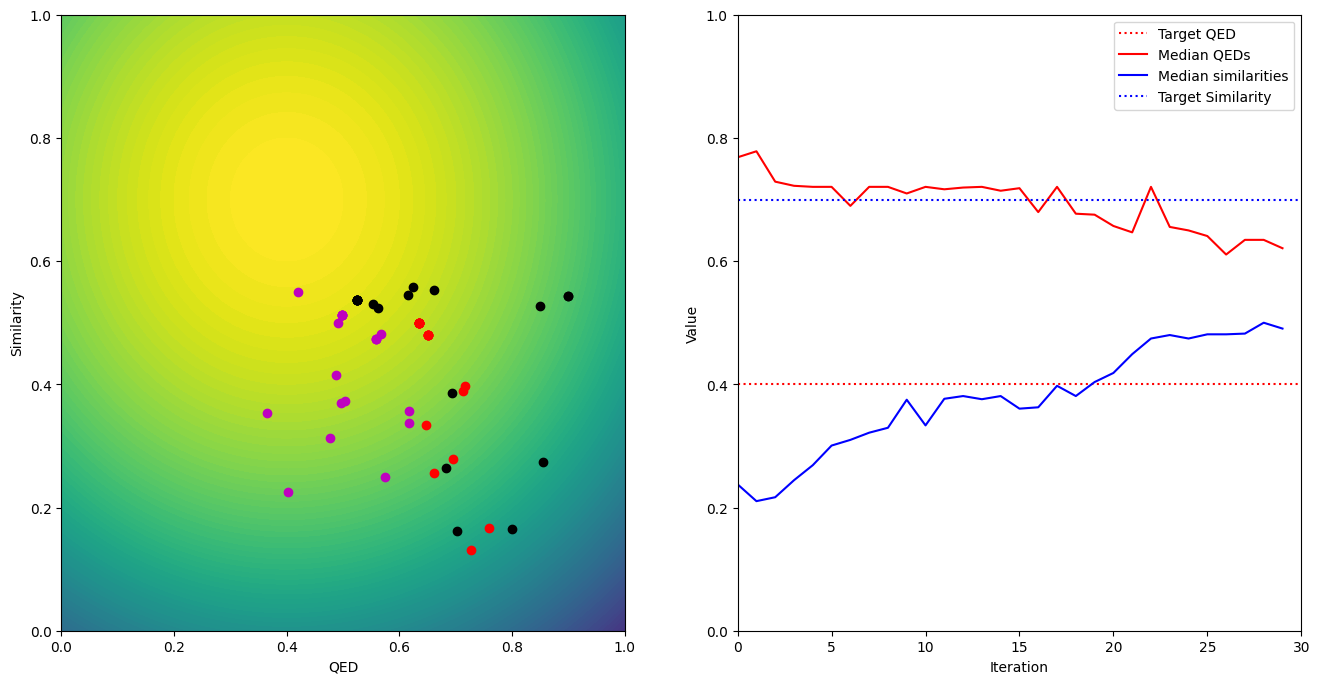

In [14]:
from IPython.display import display, clear_output
%matplotlib inline

n_steps = 30

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(16)
med_qeds = []
med_sims = []


for i in range(n_steps):
    # Business code
    print(f"Stepping {i} out of {n_steps}")
    optimizer.step()
    qeds = np.array([qed(molecule_smis) for molecule_smis in optimizer.generated_smis])
    similarities = np.array([tanimoto_similarity(molecule_smis, molecule) for molecule_smis, molecule in zip(optimizer.generated_smis, smis)])
    
    
    # plotting code
    ax1.clear()
    clear_output(wait=True)
    ax1.contourf(Xgrid, Ygrid, score_background, levels=100, vmin=0, vmax=1.0)
    ax1.set_xlabel('QED')
    ax1.set_ylabel('Similarity')    
    for i, color in enumerate(colors):
        ax1.scatter(qeds[i, :], similarities[i, :], c=color, label=f"molecule {i + 1}")
    ax2.clear()
    med_qeds.append(np.median(qeds))
    med_sims.append(np.median(similarities))
    ax2.plot([0, n_steps], [0.4, 0.4], label='Target QED', c='r', linestyle=':')
    ax2.plot(med_qeds, label='Median QEDs', c='r')
    ax2.plot(med_sims, label='Median similarities', c='b')
    ax2.plot([0, n_steps], [0.7, 0.7], label='Target Similarity', c='b', linestyle=':')
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Value")
    ax2.set_xlim(0, n_steps)
    ax2.set_ylim(0, 1)
    ax2.legend()
    display(fig)